# Hypothesis testing

Hypothesis: University towns and non-university towns have same effect on their mean housing prices during recessions.

# Data sources

1) List of university towns from wikipedia. This is a text file with 567 lines either containing state name or the name of city and the university in the city.

<img src="univ_town_list.png">

2) Housing data from Zillow containg information about house sale prices in each month from the year 1996 to 2016. A snapshot of the csv file is shown here.

<img src="zillow_housing_data.png">

3) Quarterly GDP data from US Department of Commerce, Bureau of Economic Analysis. A snapshot of the excel file is shown below.

<img src="gdp.png">

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
def get_list_of_university_towns():
    '''Returns a DataFrame of towns and the states they are in from the 
    university_towns.txt list.     
    
    Following steps were taken to extract the required information in the desired format:

    1. For "State", removing characters from "[" to the end.
    2. For "RegionName", when applicable, removing every character from " (" to the end.'''
    uni_towns=pd.DataFrame(columns=['State','RegionName'])
    with open('university_towns.txt', 'r') as f:

        #Read non-empty lines:
        data = (line.rstrip() for line in f)
        lines = list(line for line in data if line)

        #Get the index of states:
        r_idx = [lines.index(line) for line in lines if '[edit]' in line]

        #Separating states and university names using wrapping indexes:
        university = []
        state = [lines[i].replace('[edit]', '') for i in r_idx]
        for i in range(len(r_idx)):
            if i != len(r_idx)-1:
                index_range=[j for j in range(r_idx[i]+1,r_idx[i+1])]
                regions=[lines[j].split(" (")[0] for j in index_range]
                for region in regions:
                    uni_towns=uni_towns.append(pd.DataFrame([[state[i],region]],columns=['State','RegionName']),ignore_index=True)
            else:
                index_range=[j for j in range(r_idx[i]+1,len(lines))]
                regions = [lines[j].split(" (")[0] for j in index_range]
                for region in regions:
                    uni_towns=uni_towns.append(pd.DataFrame([[state[i],region]],columns=['State','RegionName']),ignore_index=True)
    return uni_towns
get_list_of_university_towns()

,State,RegionName
0,Alabama,Auburn
1,Alabama,Florence
2,Alabama,Jacksonville
3,Alabama,Livingston
4,Alabama,Montevallo
...,...,...
512,Wisconsin,River Falls
513,Wisconsin,Stevens Point
514,Wisconsin,Waukesha
515,Wisconsin,Whitewater


# Get the quarter when recession starts

Recession start is defined by two consecutive quarters of decline in GDP.

In [3]:
def get_recession_start():
    '''Returns the year and quarter of the recession start time after year 2000.'''
    gdp=pd.read_excel('gdplev.xls',usecols="E,G",skiprows=219,names=['Quarter','GDP']).set_index('Quarter')
    gdp['GDP change']=gdp['GDP']-gdp['GDP'].shift(+1)
    gdp['RecessionStart'] = (gdp['GDP change'] < 0) & (gdp['GDP change'].shift(-1) < 0)& (gdp['GDP change'].shift(+1) > 0)
    return gdp.index[gdp['RecessionStart']][0]
get_recession_start()

'2008q3'

# Get recession end quarter

Recession end is defined by two consecutive quarters with GDP increase.

In [4]:
def get_recession_end():
    '''Returns the year and quarter of the recession end time'''
    rstart=get_recession_start()
    gdp=pd.read_excel('gdplev.xls',usecols="E,G",skiprows=219,names=['Quarter','GDP']).set_index('Quarter')
    gdp['GDP change']=gdp['GDP']-gdp['GDP'].shift(+1)
    gdp['RecessionEnd'] = (gdp['GDP change'] > 0) & (gdp['GDP change'].shift(+1) > 0)&(gdp['GDP change'].shift(+2) < 0)
    #return gdp
    list_of_year=list(gdp.index[gdp['RecessionEnd']])
    for year in list_of_year:
        if(year>rstart):
            rend=year
            break
    #rend=[year in list_of_year if(year > rstart)]
    return rend
get_recession_end()

'2009q4'

# Get recession bottom

Recession bottom is defined as the quarter with minimum GDP between the start and end of recession

In [5]:
def get_recession_bottom():
    '''Returns the year and quarter of the recession bottom time'''
    rstart=get_recession_start()
    rend=get_recession_end()
    gdp=pd.read_excel('gdplev.xls',usecols="E,G",skiprows=219,names=['Quarter','GDP']).set_index('Quarter')
    rbottom=np.argmin(gdp.loc[rstart:rend,'GDP'])
    return rbottom
get_recession_bottom()

/home/shivangi/anaconda2/envs/python3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


'2009q2'

# Converting the monthly housing prices to quarterly prices

In [6]:
# Use this dictionary to map state names to two letter acronyms
states = {'OH': 'Ohio', 'KY': 'Kentucky', 'AS': 'American Samoa', 'NV': 'Nevada', 'WY': 'Wyoming', 'NA': 'National', 'AL': 'Alabama', 'MD': 'Maryland', 'AK': 'Alaska', 'UT': 'Utah', 'OR': 'Oregon', 'MT': 'Montana', 'IL': 'Illinois', 'TN': 'Tennessee', 'DC': 'District of Columbia', 'VT': 'Vermont', 'ID': 'Idaho', 'AR': 'Arkansas', 'ME': 'Maine', 'WA': 'Washington', 'HI': 'Hawaii', 'WI': 'Wisconsin', 'MI': 'Michigan', 'IN': 'Indiana', 'NJ': 'New Jersey', 'AZ': 'Arizona', 'GU': 'Guam', 'MS': 'Mississippi', 'PR': 'Puerto Rico', 'NC': 'North Carolina', 'TX': 'Texas', 'SD': 'South Dakota', 'MP': 'Northern Mariana Islands', 'IA': 'Iowa', 'MO': 'Missouri', 'CT': 'Connecticut', 'WV': 'West Virginia', 'SC': 'South Carolina', 'LA': 'Louisiana', 'KS': 'Kansas', 'NY': 'New York', 'NE': 'Nebraska', 'OK': 'Oklahoma', 'FL': 'Florida', 'CA': 'California', 'CO': 'Colorado', 'PA': 'Pennsylvania', 'DE': 'Delaware', 'NM': 'New Mexico', 'RI': 'Rhode Island', 'MN': 'Minnesota', 'VI': 'Virgin Islands', 'NH': 'New Hampshire', 'MA': 'Massachusetts', 'GA': 'Georgia', 'ND': 'North Dakota', 'VA': 'Virginia'}

In [7]:
def value2quarter(value):
    year, month = value.split("-")
    year = int(year)
    month = int(month)
    if month < 4:
        return "{}q{}".format(year, 1)
    if month < 7:
        return "{}q{}".format(year, 2)
    if month < 10:
        return "{}q{}".format(year, 3)
    return "{}q{}".format(year, 4)

def convert_housing_data_to_quarters():
    df = pd.read_csv("City_Zhvi_AllHomes.csv")
    df_t= pd.melt(df.drop(["Metro", "CountyName", "SizeRank"], axis=1), id_vars=["State", "RegionName", "RegionID",])
    df_t["yearQ"] = df_t["variable"].apply(value2quarter)
    df_t = df_t[(df_t.yearQ >= "2000q1") & (df_t.yearQ <= "2016q3")]
    df_t["State"] = df_t["State"].map(states)
    answer = df_t.groupby(
        ["State", "RegionName", "RegionID", "yearQ"]
    )["value"].mean().unstack("yearQ").reset_index().drop("RegionID", axis=1).set_index(["State", "RegionName"])
    return answer
convert_housing_data_to_quarters()

yearQ                       2000q1         2000q2         2000q3  \
State   RegionName                                                 
Alabama Adamsville    69033.333333   69166.666667   69800.000000   
        Alabaster    122133.333333  123066.666667  123166.666667   
        Albertville   73966.666667   72600.000000   72833.333333   
        Arab          83766.666667   81566.666667   81333.333333   
        Ardmore                NaN            NaN            NaN   
...                            ...            ...            ...   
Wyoming Burns        101533.333333  104566.666667  108366.666667   
        Casper        89233.333333   89600.000000   89733.333333   
        Cheyenne     116866.666667  120033.333333  121533.333333   
        Evansville   128033.333333  128766.666667  130833.333333   
        Pine Bluffs   93733.333333   95066.666667   94633.333333   

yearQ                       2000q4         2001q1         2001q2  \
State   RegionName                                                 
Alabama Adamsville    71966.666667   73466.666667   74000.000000   
        Alabaster    123700.000000  123233.333333  125133.333333   
        Albertville   74200.000000   75900.000000   76000.000000   
        Arab          82966.666667   84200.000000   84533.333333   
        Ardmore                NaN            NaN            NaN   
...                            ...            ...            ...   
Wyoming Burns        113000.000000  115833.333333  117200.000000   
        Casper        93166.666667   95500.000000   97633.333333   
        Cheyenne     123633.333333  125533.333333  126300.000000   
        Evansville   132066.666667  130566.666667  131433.333333   
        Pine Bluffs   98066.666667  103233.333333  104600.000000   

yearQ                       2001q3         2001q4         2002q1  \
State   RegionName                                                 
Alabama Adamsville    73333.333333   73100.000000   73333.333333   
        Alabaster    127766.666667  127200.000000  127300.000000   
        Albertville   72066.666667   73566.666667   76533.333333   
        Arab          81666.666667   83900.000000   87266.666667   
        Ardmore                NaN            NaN            NaN   
...                            ...            ...            ...   
Wyoming Burns        117800.000000  117633.333333  117333.333333   
        Casper        99433.333333  100633.333333  101733.333333   
        Cheyenne     126466.666667  128133.333333  128466.666667   
        Evansville   132400.000000  133466.666667  133300.000000   
        Pine Bluffs  106500.000000  104066.666667  102233.333333   

yearQ                       2002q2  ...         2014q2         2014q3  \
State   RegionName                  ...                                 
Alabama Adamsville    73133.333333  ...   77066.666667   75966.666667   
        Alabaster    128000.000000  ...  147133.333333  147633.333333   
        Albertville   76366.666667  ...   84033.333333   84766.666667   
        Arab          87700.000000  ...  113366.666667  111700.000000   
        Ardmore                NaN  ...  140533.333333  139566.666667   
...                            ...  ...            ...            ...   
Wyoming Burns        117233.333333  ...  168866.666667  161933.333333   
        Casper       101533.333333  ...  175766.666667  177300.000000   
        Cheyenne     129633.333333  ...  177466.666667  176733.333333   
        Evansville   131066.666667  ...  296733.333333  305666.666667   
        Pine Bluffs  103566.666667  ...  148666.666667  154366.666667   

yearQ                       2014q4         2015q1         2015q2  \
State   RegionName                                                 
Alabama Adamsville    71900.000000   71666.666667   73033.333333   
        Alabaster    148700.000000  148900.000000  149566.666667   
        Albertville   86800.000000   88466.666667   89500.000000   
        Arab         111600.000000  110166.666667  1094

# Exploring the effect of recession on housing prices in university and non-university towns

In [8]:
df_university = get_list_of_university_towns()
df_university["is_univ_town"] = True
df_university = df_university.set_index(["State", "RegionName"])
df_housing_data = convert_housing_data_to_quarters()
df_all = df_housing_data.merge(df_university, left_index=True, right_index=True, how="left")
df_all["is_univ_town"] = df_all["is_univ_town"].fillna(False)
start = "2008q3"# get_recession_start()
bottom = "2009q2"# get_recession_bottom()
df_all["ratio"] = df_all[bottom]/df_all[start]
mean_price_ratio_univ = df_all.loc[df_all.is_univ_town, "ratio"].dropna()
mean_price_ratio_no_univ = df_all.loc[~df_all.is_univ_town, "ratio"].dropna()

(0.967891003753308, 0.06435067670521108)

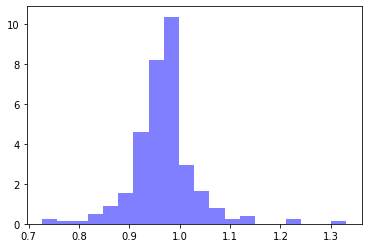

In [9]:
n1, bins1, patches1 = plt.hist(mean_price_ratio_univ, 20, density=True, facecolor='blue', alpha=0.5)
(mu_unitown, sigma_unitown) = norm.fit(mean_price_ratio_univ)
mu_unitown,sigma_unitown


(0.9559364550248012, 0.07270502006329081)

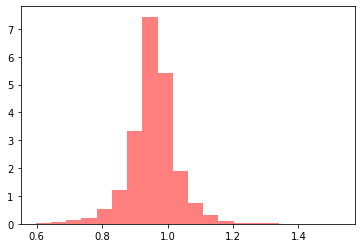

In [10]:
n2, bins2, patches2 = plt.hist(mean_price_ratio_no_univ, 20, density=True, facecolor='red', alpha=0.5)
(mu_non_unitown, sigma_non_unitown) = norm.fit(mean_price_ratio_no_univ)
mu_non_unitown,sigma_non_unitown

# Run t-test (Welch's t-test)

The variance of both samples are different hence use Welch's t-test (https://en.wikipedia.org/wiki/Student%27s_t-test#Independent_two-sample_t-test)

<img src="welch_ttest.png">

In [11]:
def run_ttest():

    statistic, pval = ttest_ind(
        mean_price_ratio_univ, 
        mean_price_ratio_no_univ, equal_var=False)
    different = pval < 0.01
    better = "university town" if mean_price_ratio_univ.mean() > mean_price_ratio_no_univ.mean() else "non-university town"
    return (different, pval, better)
run_ttest()

(True, 0.003689592222498831, 'university town')

# Conclusion: The university town housing prices are less affected by recession in 2008.

## Few points for further exploration:
### Is it true for all recession period?
### Is it true for all kinds of housing (condo, apartements, houses etc.)?